# New Na-22 notebook

May 2017
This notebook replaces the old one; this analysis uses the XAMSAnalysis class and has the correct gain set.


## Imports and settings

In [1]:
%run '../definitions.ipynb'
%run '../treemakers.ipynb'
%run '../Analysis_class.ipynb'

/home/erik/anaconda3/envs/pax/lib/python3.4/site-packages/IPython/kernel/__init__.py:13: ShimWarning: The `IPython.kernel` package has been deprecated. You should import from ipykernel or jupyter_client instead.
  "You should import from ipykernel or jupyter_client instead.", ShimWarning)


In [2]:
# Toggle data location
local_data = True

In [3]:
if local_data:
    processed_data_path = '/home/erik/win/data/xams_run8/processed/low_pmt_gain/'
    minitree_path = '/home/erik/win/data/xams_run8/minitrees/'
else:
    processed_data_path = '/data/xenon/xams/run8/processed/data/'
    minitree_path = '/data/xenon/xams/run8/minitrees/'

In [4]:
run_names_na = get_run_list(processed_data_path, '170323_155714', '170323_161452')

Run list contains 3 files


## Load data and first corrections

In [5]:
x = XAMSAnalysis(run_names_na, processed_data_path, minitree_path, include_NaI=True)

In [6]:
x.load()

In [7]:
x.corr_pmtgains([2e6, 0, 0, 2e6, 0, 0,0,0], [700, 750], verbose=True)

Using gains 348024.498913 and 263218.098600, factors 5.746722 and 7.598262, PMT1 and 2 respectively.


In [8]:
# Using gains 417501.174012 and 256664.096882, factors 4.790406 and 7.792286, PMT1 and 2 respectively.

## Cuts

### At least one interaction

In [9]:
x.cut_interaction_exists()

Finite s1 selection: 6127 rows removed (93.48% passed)


### Single scatter

largest_other_s1 below 10 selection: 10508 rows removed (88.04% passed)


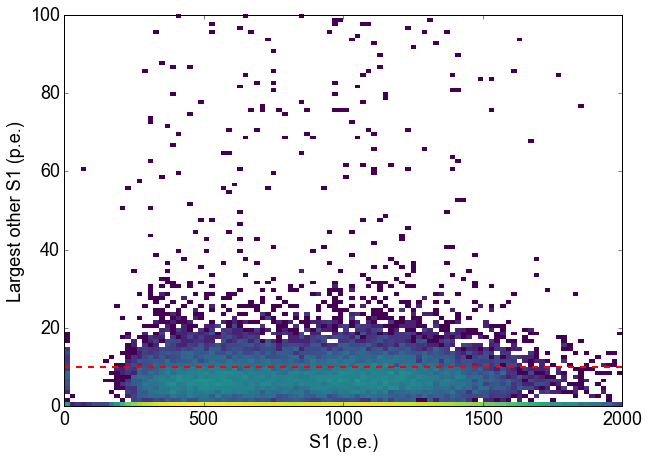

In [10]:
x.cut_largest_other_s1(largest_other_s1_max=10, plot=True, apply=True, bins=100, 
                       norm=LogNorm(), range=((0, 2000), (0, 100)))

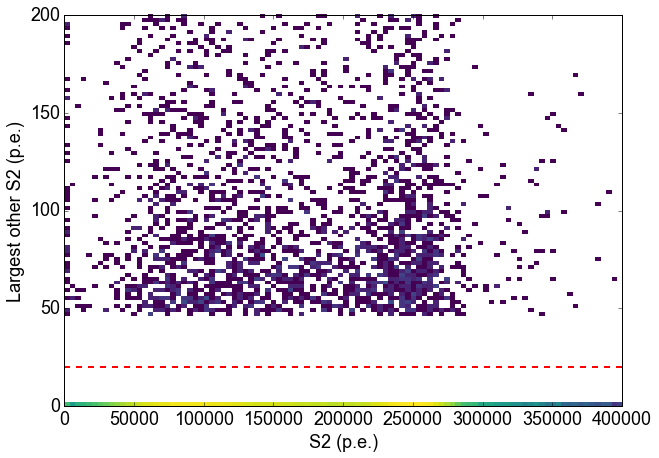

largest_other_s2 below 20 selection: 21333 rows removed (72.43% passed)


In [11]:
x.cut_largest_other_s2(largest_other_s2_max=20, 
                       plot=True, apply=True, bins=100, norm=LogNorm(), range=((0, 400e3), (0, 200)))

### Thresholds

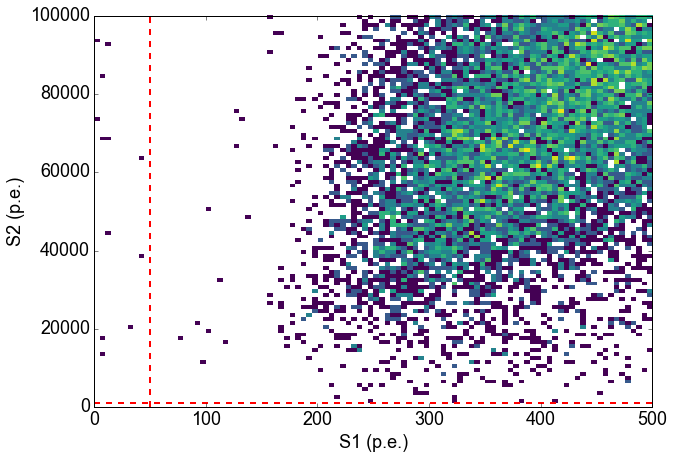

s1 above 50 selection: 25 rows removed (99.96% passed)
s2 above 1000 selection: 107 rows removed (99.81% passed)


In [12]:
x.cut_thresholds(s1_threshold=50, s2_threshold=1000,
    apply=True, plot=True, bins=100, norm=LogNorm(), range=((0, 500), (0, 100e3)))

### Saturation

s1_n_saturated_channels below 1 selection: 0 rows removed (100.00% passed)
s2_n_saturated_channels below 1 selection: 26 rows removed (99.95% passed)


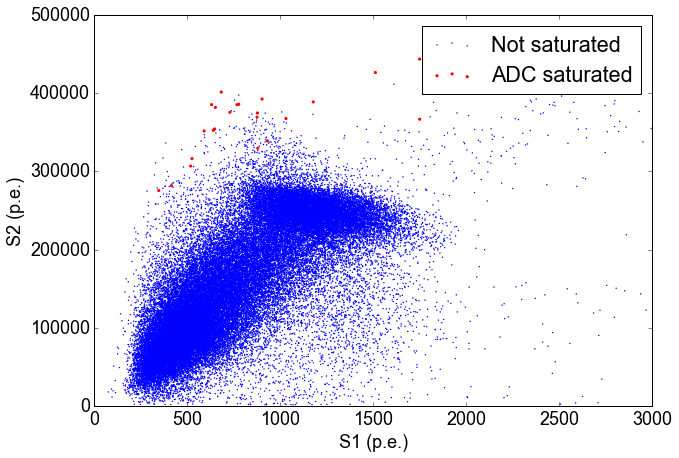

In [13]:
x.cut_saturation(apply=True, plot=True)
plt.xlim(0, 3000)
plt.ylim(0, 500e3)
plt.show()

### S1 AFT

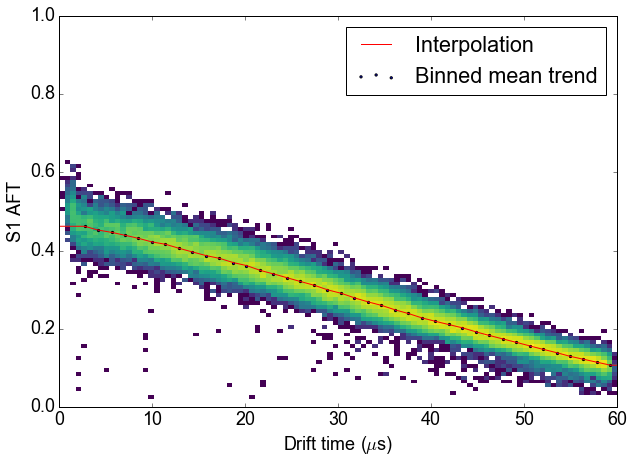

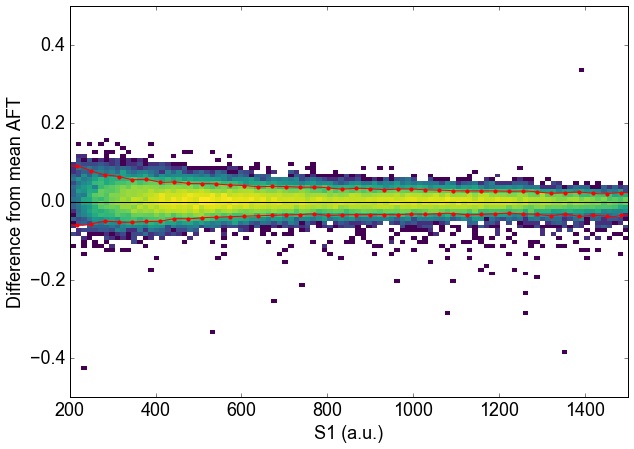

AFT_Upper selection: 2780 rows removed (95.03% passed)
AFT_Lower selection: 2932 rows removed (94.48% passed)


In [14]:
x.cut_s1_aft(plot=True, apply=True, s1_range=(200, 1500), s1_bins=40, dt_range=(2, 60), dt_bins=40)

### Drift time

drift_time in [0, 60) selection: 1 rows removed (100.00% passed)


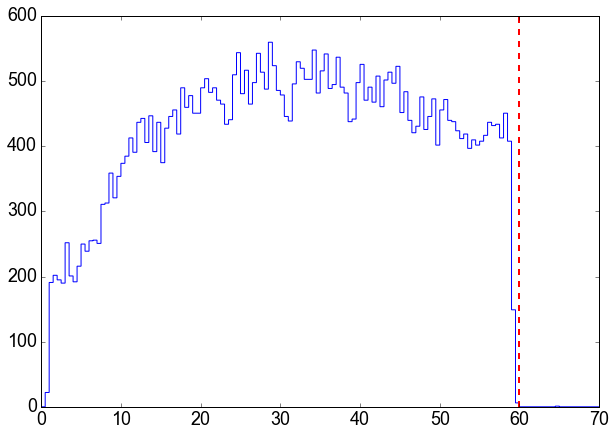

In [15]:
x.cut_drift_time(apply=True, plot=True, range=(0, 70), bins=140, histtype='step')

## Corrections

### Compute S1 LY correction

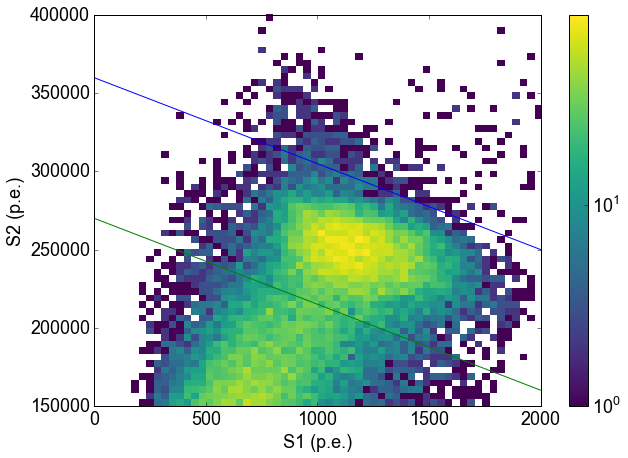

In [16]:
x.plot_s1s2(bins=60, norm=LogNorm(), range=((0, 2000), (150e3, 400e3)))
x_plot = np.linspace(0, 2e3, 10)
def upper(s1):
    return 360e3 - 55 * s1
def lower(s1):
    return 270e3 - 55 * s1
plt.plot(x_plot, upper(x_plot))
plt.plot(x_plot, lower(x_plot))
plt.colorbar()
plt.show()

In [17]:
d = x.d
# Select photopeak
d = d[(d['s2'] < upper(d['s1'])) & (d['s2'] > lower(d['s1']))]

In [18]:
def p2(x, a0, a1, a2):
    return a0 + a1 * x + a2 * x**2

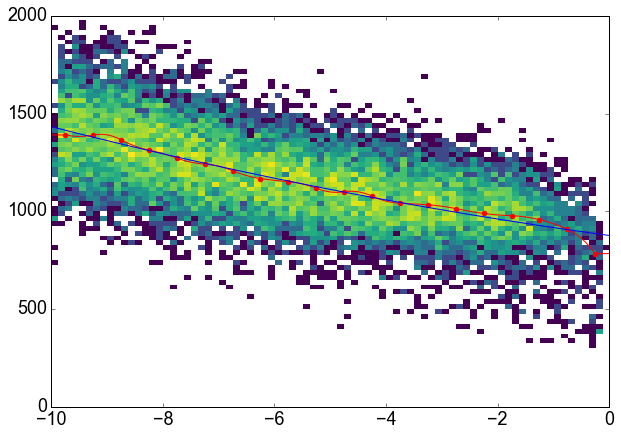

In [19]:
x1, y1 = get_trend(d['z'], d['s1'], x_range=(-10,0), bins=20)
f = my_interp(x1,y1,kind='quadratic')
popt, pcov = scipy.optimize.curve_fit(p2, d['z'], d['s1'], p0=[500, 1, 10])
pickle.dump((x1,y1), open('na22_ly.pickle', 'wb'))
pickle.dump((p2, popt, pcov), open('na22_ly_poly.pickle', 'wb'))

plt.hist2d(d['z'], d['s1'], bins=80, norm=LogNorm(), range=((-10,0), (0,2000)))
x_plot = np.linspace(-10,0, 500)
plt.plot(x_plot, f(x_plot), color='red')
plt.plot(x_plot, p2(x_plot, *popt))


plt.scatter(x1,y1, color='red')
plt.show()

In [20]:
popt

array([ 877.46920757,  -38.57954303,    1.71019834])

### Apply S1 correction

In [21]:
# Use the Na-22 derived LCE correction
x.corr_s1_ly_poly()

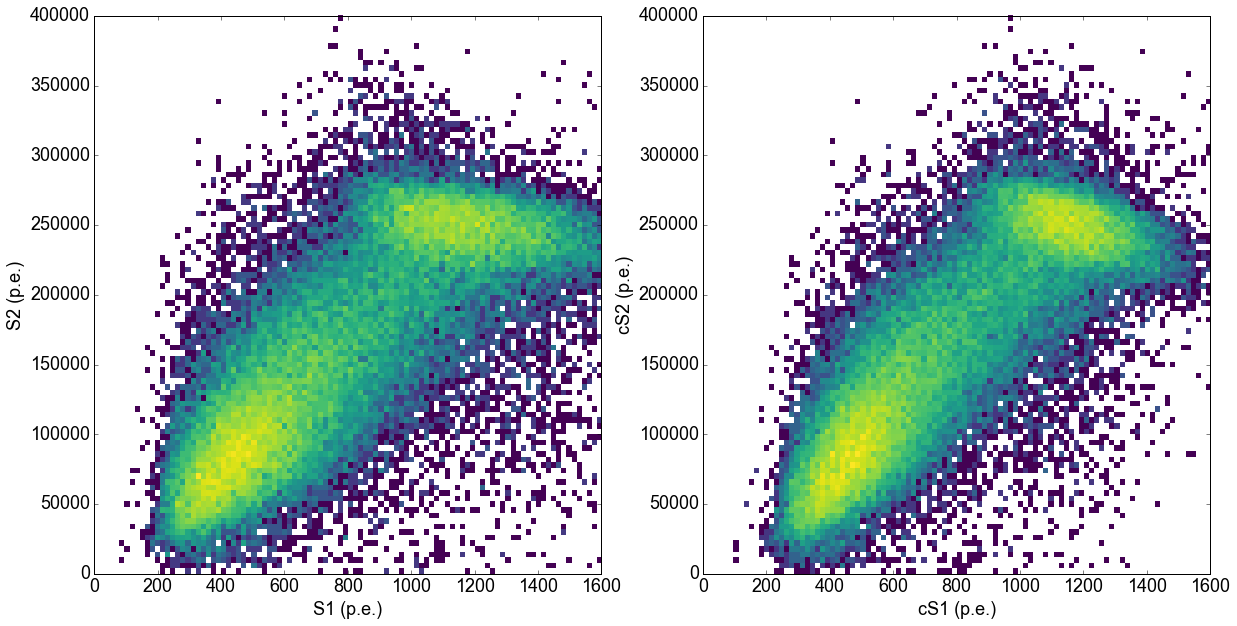

In [22]:
plt.figure(figsize=(20,10))
plt.subplot(121)
x.plot_s1s2(bins=100, range=((0,1600), (0, 400e3)), norm=LogNorm())
plt.subplot(122)
x.plot_cs1cs2(bins=100, range=((0,1600), (0, 400e3)), norm=LogNorm())

### S2 vs bottom s2

In [23]:
d=  x.d

In [24]:
x2, y2= pickle.load(open('cs137_s2aft_v_s2.pickle', 'rb'))

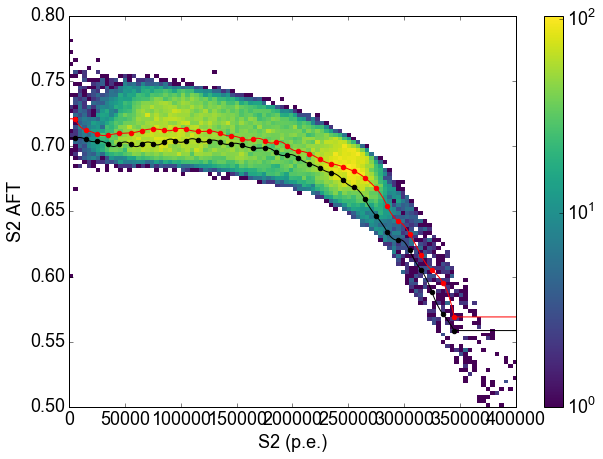

In [25]:
x1, y1 = get_trend(d['s2'], d['s2_area_fraction_top'], x_range=(0, 350e3), bins=35)
f1 = my_interp(x1, y1)
f2 = my_interp(x2, y2)

plt.hist2d(d['s2'], d['s2_area_fraction_top'], bins=100, norm=LogNorm(), range=((0, 400e3), (0.5, 0.8)))
plt.colorbar()
x_plot=np.linspace(0, 400e3, 500)

plt.plot(x_plot, f1(x_plot), color='red')
plt.scatter(x1, y1, color='red')

plt.plot(x_plot, f2(x_plot), color='black', label='Cs137 trend')
plt.scatter(x2, y2, color='black')

plt.xlabel('S2 (p.e.)')
plt.ylabel('S2 AFT')
plt.show()

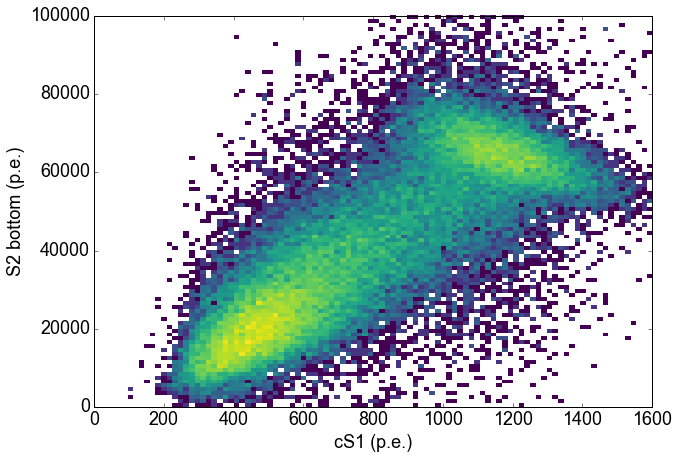

In [26]:
x.plot_cs1bs2(bins=100, range=((0, 1600), (0, 100e3)), norm=LogNorm())

### S2 decrease

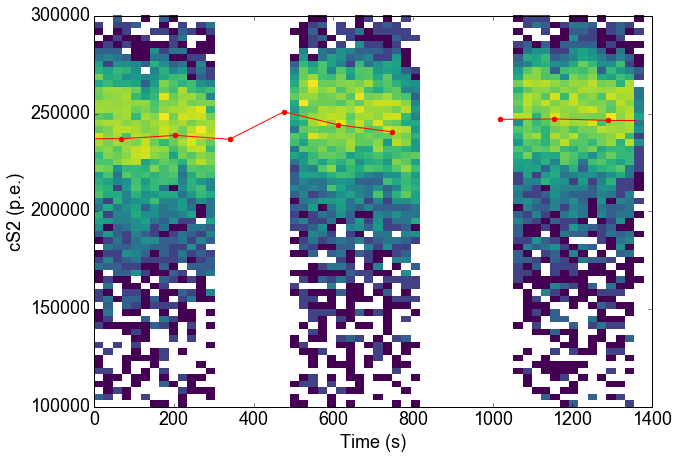

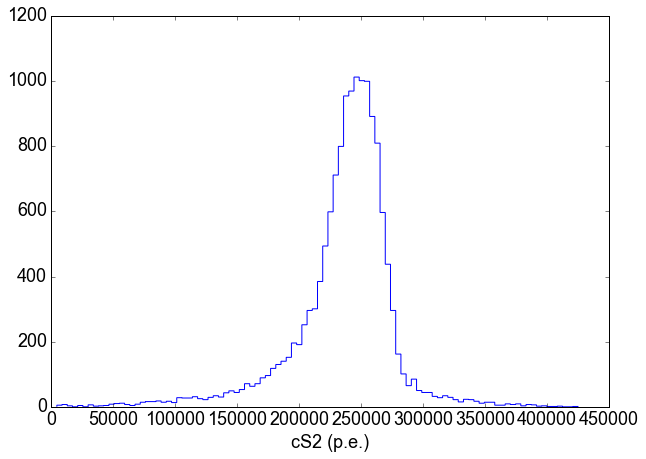

In [27]:
x.corr_s2_sag(plot=True, apply=False, cs1_range=(1000, 11000), cs2_cutoff=100, bins=60, norm=LogNorm(), 
              range=((0, 1400), (100e3, 300e3)))

## Fit

### Binned fit

In [28]:
def build_fit_lists(x, y, x_range, y_range, x_bins, y_bins):
    x_bin_edges = np.linspace(x_range[0], x_range[1], x_bins+1)
    y_bin_edges = np.linspace(y_range[0], y_range[1], y_bins+1)
    
    
    # Loop over all bins first in x then in y and count the number of entries in that bin
    # Slightly inefficient code
    counts = []
    for left_y, right_y in zip(y_bin_edges[:-1], y_bin_edges[1:]):
        x_sub = x[(y >= left_y) & (y < right_y)]
        for left_x, right_x in zip(x_bin_edges[:-1], x_bin_edges[1:]):
            counts.append(sum((x_sub >= left_x) & (x_sub < right_x)))
    
    
    
    x_list = [0.5*(left_x + right_x)
              for left_y, right_y in zip(y_bin_edges[:-1], y_bin_edges[1:])
              for left_x, right_x in zip(x_bin_edges[:-1], x_bin_edges[1:])
              ]
    y_list = [0.5*(left_y + right_y)
              for left_y, right_y in zip(y_bin_edges[:-1], y_bin_edges[1:])
              for left_x, right_x in zip(x_bin_edges[:-1], x_bin_edges[1:])
              ]
    
    return np.array(counts), np.array(x_list), np.array(y_list)

In [29]:
def twoD_Gaussian(xdata_tuple, amplitude, xo, yo, sigma_x, sigma_y, theta, offset):
    (x, y) = xdata_tuple 
    xo = float(xo)
    yo = float(yo)    
    a = (np.cos(theta)**2)/(2*sigma_x**2) + (np.sin(theta)**2)/(2*sigma_y**2)
    b = -(np.sin(2*theta))/(4*sigma_x**2) + (np.sin(2*theta))/(4*sigma_y**2)
    c = (np.sin(theta)**2)/(2*sigma_x**2) + (np.cos(theta)**2)/(2*sigma_y**2)
    g = offset + amplitude*np.exp( - (a*((x-xo)**2) + 2*b*(x-xo)*(y-yo) 
                            + c*((y-yo)**2)))
    return g #.ravel()

#### Build lists

In [30]:
d = x.d
pickle.dump(d, open('./fit2d_mwe/d.pickle', 'wb'))

In [31]:
cs1_range = (850, 1600)
cs2_range = (48e3, 80e3)
cs1_bins = 40
cs2_bins = 40


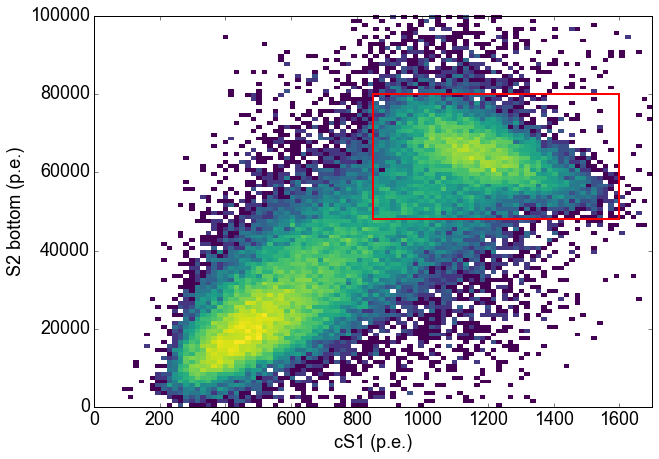

In [32]:
x.plot_cs1bs2(bins=100, norm=LogNorm(), range=((0, 1700), (0, 100e3)))
draw_box(cs1_range, cs2_range, edgecolor='red', lw=2)

In [33]:
counts, x_fit, y_fit = build_fit_lists(d['cs1'], d['s2_bot'], cs1_range, cs2_range, cs1_bins, cs2_bins)

#### Refine selection

In [34]:
def cut1(x):
    return 98e3 - 37*x   
def cut2(x):
    return 120e3 - 37*x  


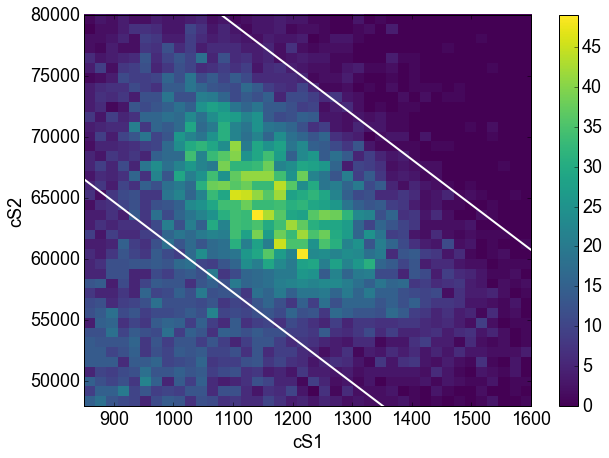

In [35]:
plt.hist2d(d['cs1'], d['s2_bot'], bins=(cs1_bins, cs2_bins), range=(cs1_range, cs2_range))#, norm=LogNorm())

x_plot = np.linspace(*cs1_range, num=20)
for cut in [cut1, cut2]:
    plt.plot(x_plot, cut(x_plot), color='white', lw=2)
plt.colorbar()
plt.xlabel('cS1')
plt.ylabel('cS2')
plt.show()

In [36]:
sel = (cut1(x_fit) < y_fit) & (cut2(x_fit) > y_fit)

In [37]:
initial_guess = (70,1100,65000,30,2000,-0.03,0)
popt, pcov = scipy.optimize.curve_fit(twoD_Gaussian, (x_fit[sel], y_fit[sel]), counts[sel], p0=initial_guess)
print('cS1 peak position: %.1f' % (popt[1]))
print('cS2 peak position: %.1f' % (popt[2]))

cS1 peak position: 1156.6
cS2 peak position: 64741.3


In [38]:
delta1 = 1
delta2 = 100
x1 = np.arange(*cs1_range, step=delta1)
y1 = np.arange(*cs2_range, step=delta2)

X, Y = np.meshgrid(x1, y1)
Z = twoD_Gaussian((X,Y), *popt)

In [39]:
def plot_e_line(e, g1 = 0.07099636,  g2 = 3.08170177, **kwargs):
    x_plot = np.linspace(0, 2e3, 100)
    y_plot = g2 * (e / 13.7e-3 - x_plot / g1)
    plt.plot(x_plot, y_plot, **kwargs)

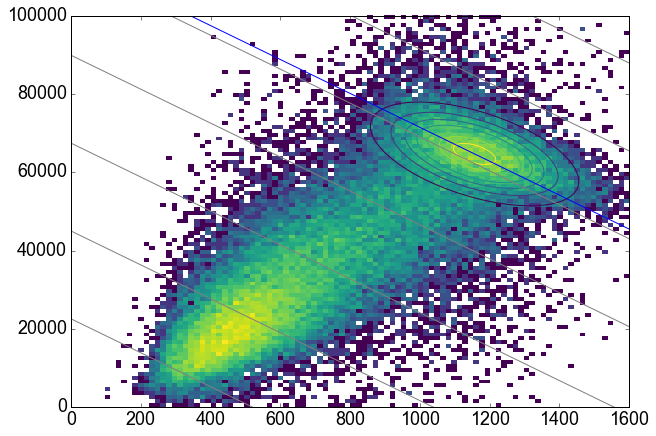

In [40]:
plt.hist2d(d['cs1'], d['s2_bot'], bins=100, norm=LogNorm(), range=((0, 1600),(0, 100e3)))
plot_e_line(511)
for e in np.arange(0, 800, 100):
    plot_e_line(e, color='gray')
plt.contour(X, Y, Z)

plt.show()

### Unbinned fit

In [41]:
print('Pending...')

Pending...


## Energy

In [42]:
x.add_ces()

In [43]:
x.add_e_s1(energy=511, cs1_peak=1156.6)
x.add_e_s2(energy=511, cs2_peak=64741.3)

In [44]:
d = x.d

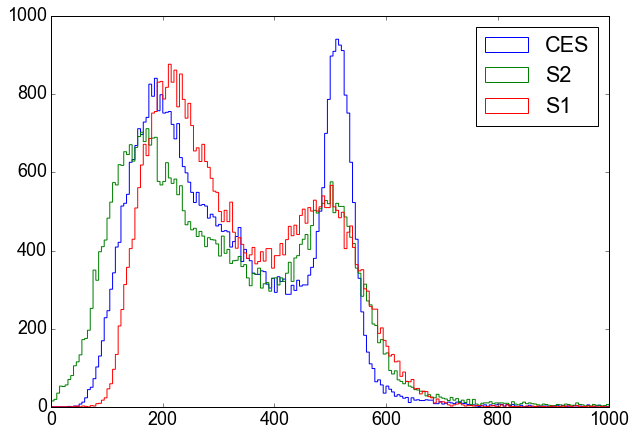

In [45]:
plt.hist(d['e_ces'], bins=200, histtype='step', range=(0, 1e3), label='CES')
plt.hist(d['e_s2'], bins=200, histtype='step', range=(0, 1e3), label='S2')
plt.hist(d['e_s1'], bins=200, histtype='step', range=(0, 1e3), label='S1')
#plt.yscale('log')
plt.legend(loc='upper right')
plt.show()

### Unbinned fits

In [46]:
%run '../definitions.ipynb'

-2977.95435008


/home/erik/anaconda3/envs/pax/lib/python3.4/site-packages/ipykernel/__main__.py:20: InitialParamWarning: errordef is not given. Default to 1.
/home/erik/anaconda3/envs/pax/lib/python3.4/site-packages/ipykernel/__main__.py:20: InitialParamWarning: Parameter a0 is floating but does not have initial step size. Assume 1.
/home/erik/anaconda3/envs/pax/lib/python3.4/site-packages/ipykernel/__main__.py:20: InitialParamWarning: Parameter mu is floating but does not have initial step size. Assume 1.
/home/erik/anaconda3/envs/pax/lib/python3.4/site-packages/ipykernel/__main__.py:20: InitialParamWarning: Parameter sigma is floating but does not have initial step size. Assume 1.
/home/erik/anaconda3/envs/pax/lib/python3.4/site-packages/ipykernel/__main__.py:20: InitialParamWarning: Parameter off is floating but does not have initial step size. Assume 1.
/home/erik/anaconda3/envs/pax/lib/python3.4/site-packages/ipykernel/__main__.py:20: InitialParamWarning: Parameter slope is floating but does not 

FCN = -3226.564205079159 
 TOTAL NCALL = 257 
 NCALLS = 257 
 
 
 EDM = 2.8854432161575727e-08 
 GOAL EDM = 1e-05 
 
 UP = 1.0 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,a0,226.699,22.5214,0,0,,,
2,mu,515.238,0.582265,0,0,,,
3,sigma,32.3704,0.91111,0,0,,,
4,off,300.451,14.2397,0,0,,,
5,slope,-0.483384,0.0229163,0,0,,,


0.06282611119786906


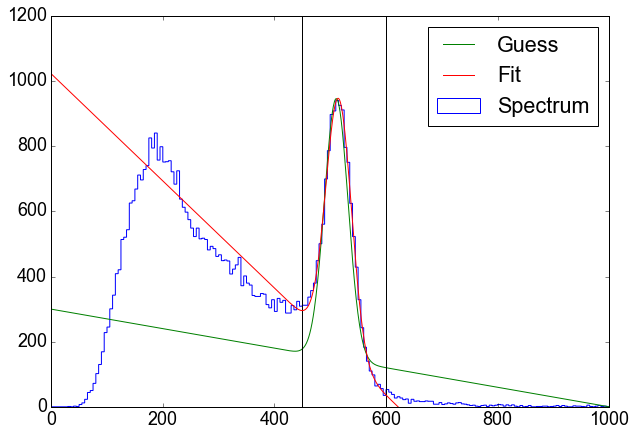

In [65]:
popt_ces, m_ces, norm = fit_gaus_with_bg(d['e_ces'].values, (450, 600), 800,  511, 30, 300, -0.3)
plt.ylim(0, 1200)
plt.show()

-264.516192156


/home/erik/anaconda3/envs/pax/lib/python3.4/site-packages/ipykernel/__main__.py:20: InitialParamWarning: errordef is not given. Default to 1.
/home/erik/anaconda3/envs/pax/lib/python3.4/site-packages/ipykernel/__main__.py:20: InitialParamWarning: Parameter a0 is floating but does not have initial step size. Assume 1.
/home/erik/anaconda3/envs/pax/lib/python3.4/site-packages/ipykernel/__main__.py:20: InitialParamWarning: Parameter mu is floating but does not have initial step size. Assume 1.
/home/erik/anaconda3/envs/pax/lib/python3.4/site-packages/ipykernel/__main__.py:20: InitialParamWarning: Parameter sigma is floating but does not have initial step size. Assume 1.
/home/erik/anaconda3/envs/pax/lib/python3.4/site-packages/ipykernel/__main__.py:20: InitialParamWarning: Parameter off is floating but does not have initial step size. Assume 1.
/home/erik/anaconda3/envs/pax/lib/python3.4/site-packages/ipykernel/__main__.py:20: InitialParamWarning: Parameter slope is floating but does not 

FCN = -544.210804097976 
 TOTAL NCALL = 244 
 NCALLS = 244 
 
 
 EDM = 1.8949283756129058e-05 
 GOAL EDM = 1e-05 
 
 UP = 1.0 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,a0,197.525,64.9551,0,0,,,
2,mu,498.216,3.78416,0,0,,,
3,sigma,83.0816,10.11,0,0,,,
4,off,444.881,130.285,0,0,,,
5,slope,-0.635991,0.186566,0,0,,,


0.16675798276808196


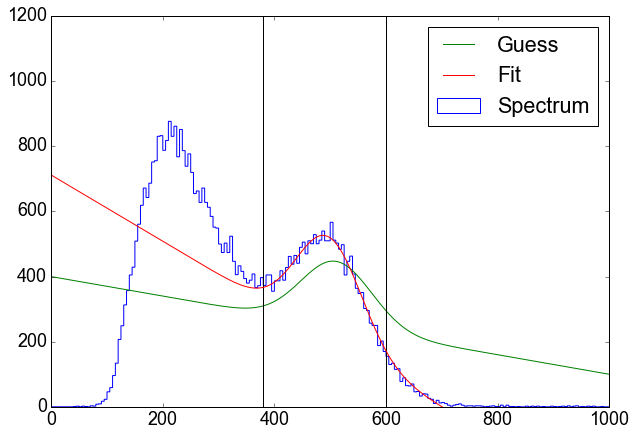

In [48]:
popt, m, norm = fit_gaus_with_bg(d['e_s1'].values, (380, 600), 200,  511, 90, 400, -0.3)
plt.ylim(0, 1200)
plt.show()

-386.227722495


/home/erik/anaconda3/envs/pax/lib/python3.4/site-packages/ipykernel/__main__.py:20: InitialParamWarning: errordef is not given. Default to 1.
/home/erik/anaconda3/envs/pax/lib/python3.4/site-packages/ipykernel/__main__.py:20: InitialParamWarning: Parameter a0 is floating but does not have initial step size. Assume 1.
/home/erik/anaconda3/envs/pax/lib/python3.4/site-packages/ipykernel/__main__.py:20: InitialParamWarning: Parameter mu is floating but does not have initial step size. Assume 1.
/home/erik/anaconda3/envs/pax/lib/python3.4/site-packages/ipykernel/__main__.py:20: InitialParamWarning: Parameter sigma is floating but does not have initial step size. Assume 1.
/home/erik/anaconda3/envs/pax/lib/python3.4/site-packages/ipykernel/__main__.py:20: InitialParamWarning: Parameter off is floating but does not have initial step size. Assume 1.
/home/erik/anaconda3/envs/pax/lib/python3.4/site-packages/ipykernel/__main__.py:20: InitialParamWarning: Parameter slope is floating but does not 

FCN = -693.9919812179146 
 TOTAL NCALL = 282 
 NCALLS = 282 
 
 
 EDM = 1.4973789188360824e-05 
 GOAL EDM = 1e-05 
 
 UP = 1.0 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,a0,314.311,90.6208,0,0,,,
2,mu,505.389,2.32971,0,0,,,
3,sigma,65.9806,5.60966,0,0,,,
4,off,594.961,154.817,0,0,,,
5,slope,-0.847861,0.220993,0,0,,,


0.1305540990141281


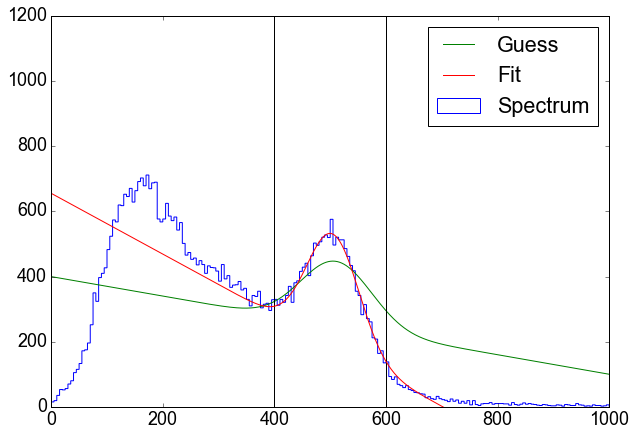

In [49]:
popt, m, norm = fit_gaus_with_bg(d['e_s2'].values, (400, 600), 200,  511, 90, 400, -0.3)
plt.ylim(0, 1200)
plt.show()

### Note to self

Hmmm. the energy that comes from the fit is not exactly 511 keV. Is the 2D fit somehow a bit wrong? Alternatively, do not make a fancy fit but do the 1d fits and get the center from that. BTW, is the uniform BG justified? What if you throw it out?

## NaI

In [50]:
x.cut_NaI_interaction_exists()

Finite NaI_area selection: 16 rows removed (99.97% passed)


In [51]:
d = x.d

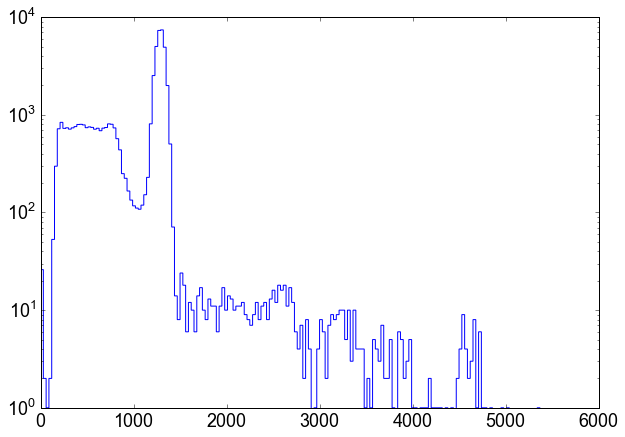

In [52]:
plt.hist(d['NaI_area'], bins=200, histtype='step', range=(0, 6e3))
plt.yscale('log')
plt.show()

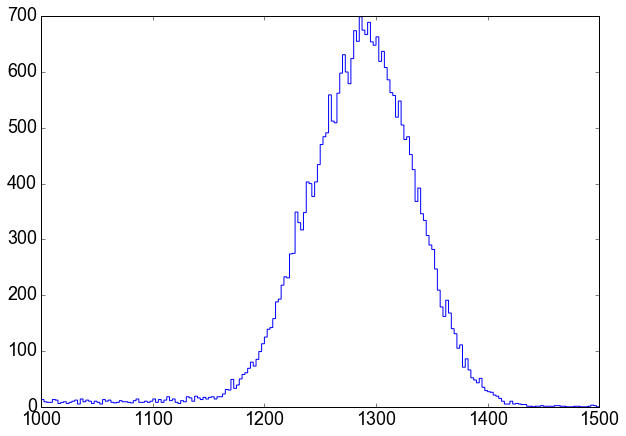

In [53]:
plt.hist(d['NaI_area'], bins=200, histtype='step', range=(1000, 1.5e3))
#plt.yscale('log')
plt.show()

/home/erik/anaconda3/envs/pax/lib/python3.4/site-packages/ipykernel/__main__.py:30: InitialParamWarning: errordef is not given. Default to 1.
/home/erik/anaconda3/envs/pax/lib/python3.4/site-packages/ipykernel/__main__.py:30: InitialParamWarning: Parameter mu is floating but does not have initial step size. Assume 1.
/home/erik/anaconda3/envs/pax/lib/python3.4/site-packages/ipykernel/__main__.py:30: InitialParamWarning: Parameter sigma is floating but does not have initial step size. Assume 1.


FCN = -5164.896874782026 
 TOTAL NCALL = 54 
 NCALLS = 54 
 
 
 EDM = 1.7760860212355633e-10 
 GOAL EDM = 1e-05 
 
 UP = 1.0 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,mu,1287.81,0.427751,0,0,,,
2,sigma,65.3044,0.544303,0,0,,,


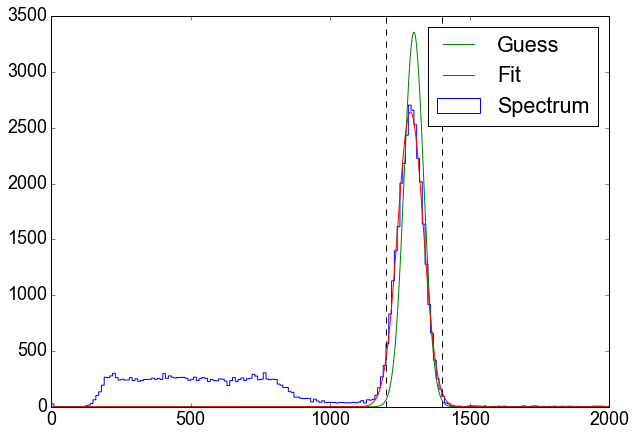

In [55]:
bla = fit_gaus(d['NaI_area'],(1200,1400), 1300,50, plot_range=(0, 2000), int_step=0.1)

### Energy

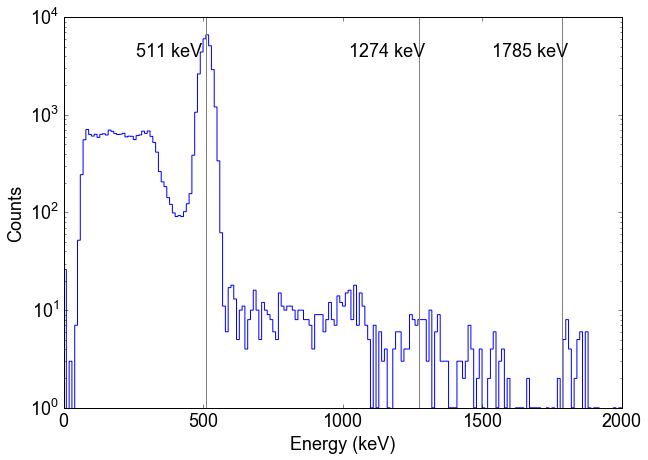

In [57]:
plt.hist(d['NaI_energy'], bins=200, histtype='step', range=(0, 2e3))
plt.yscale('log')
for e in [511, 1274, 1274 + 511]:
    plt.axvline(e, color='gray')
    plt.text(e-250, 4e3, '%d keV' % e)
plt.xlabel('Energy (keV)')
plt.ylabel('Counts')
plt.show()

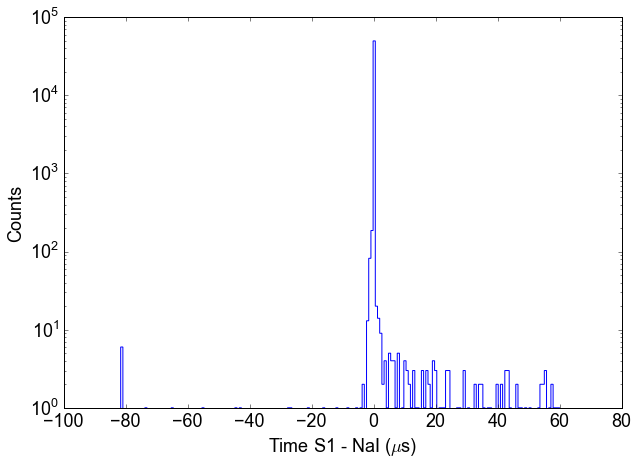

In [58]:
plt.hist(d['NaI_time_from_s1']*1e-3, bins=200, histtype='step')
plt.yscale('log')
plt.xlabel('Time S1 - NaI ($\mu$s)')
plt.ylabel('Counts')
plt.show()

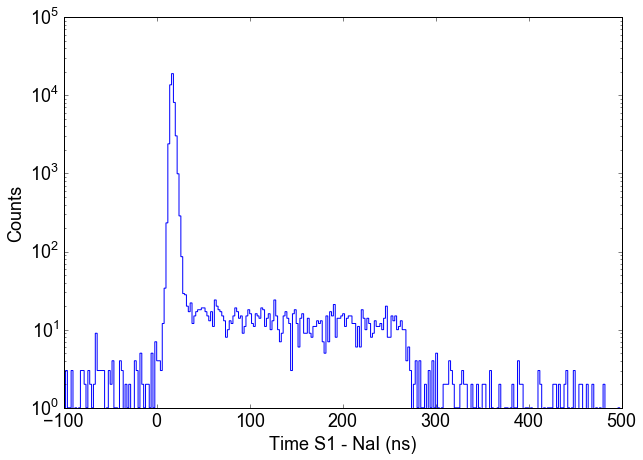

In [59]:
plt.hist(d['NaI_time_from_s1'], bins=300, histtype='step', range=(-100,500))
plt.yscale('log')
plt.xlabel('Time S1 - NaI (ns)')
plt.ylabel('Counts')
plt.show()

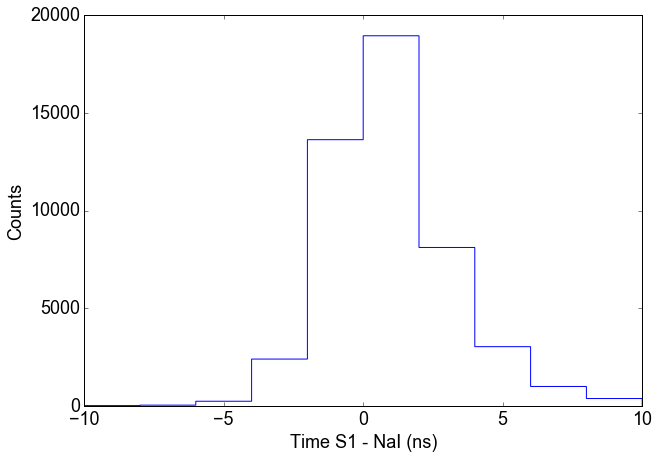

In [60]:
plt.hist(d['NaI_time_from_s1_corr'], bins=10, histtype='step', range=(-10,10))
#plt.yscale('log')
plt.xlabel('Time S1 - NaI (ns)')
plt.ylabel('Counts')
plt.show()

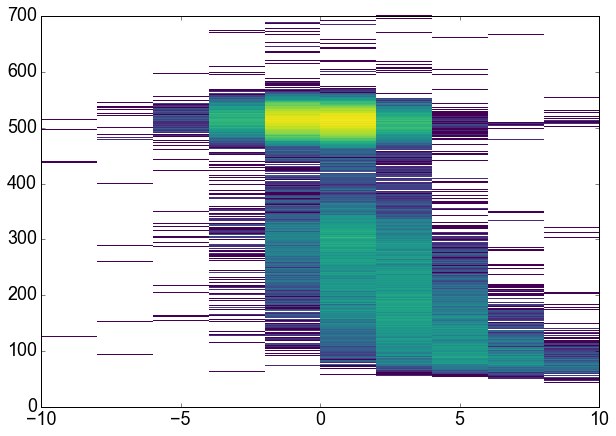

In [61]:
plt.hist2d(d['NaI_time_from_s1_corr'], d['NaI_energy'], range=((-10,10), (0, 700)), bins=(10, 700), norm=LogNorm())
plt.show()

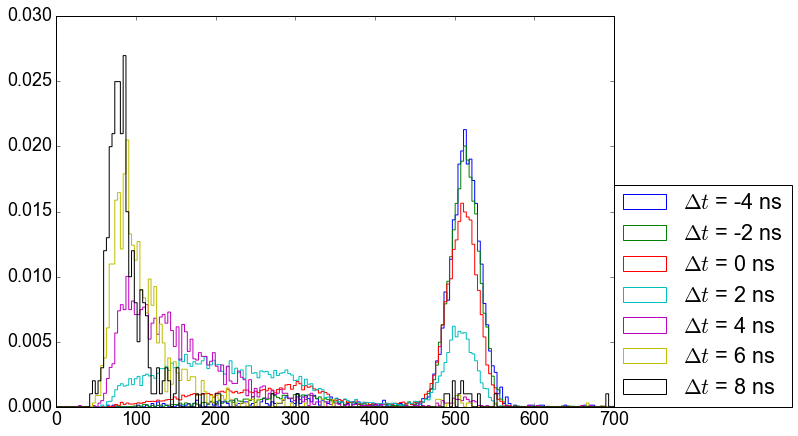

In [62]:
for dt in np.linspace(-4, 8, 7):
    plt.hist(d[d['NaI_time_from_s1_corr'] == dt]['NaI_energy'], bins=200, range=(0, 700), 
             histtype='step', normed=True, label='$\Delta t$ = %.0f ns' % dt )
plt.legend(loc=(1,0))
plt.show()

### JNice

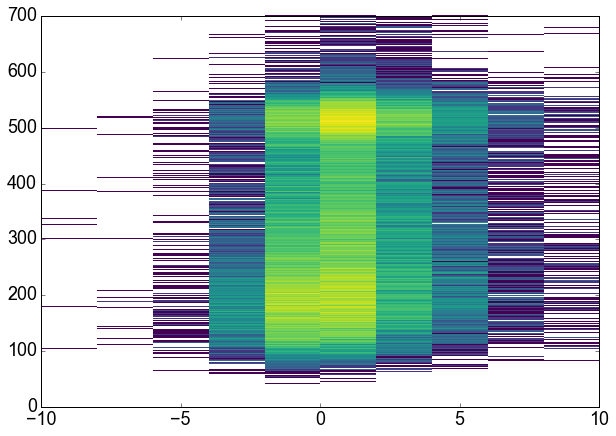

In [63]:
plt.hist2d(d['NaI_time_from_s1_corr'], d['e_ces'], range=((-10,10), (0, 700)), bins=(10, 700), norm=LogNorm())
plt.show()

-4.0 2393
-2.0 13626
0.0 18947
2.0 8107
4.0 3028


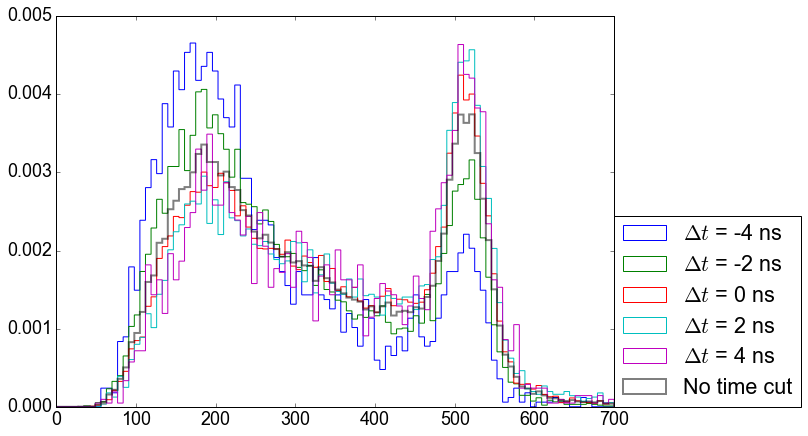

In [64]:
for dt in np.linspace(-4, 4, 5):
    plt.hist(d[d['NaI_time_from_s1_corr'] == dt]['e_ces'], bins=100, range=(0, 700), 
             histtype='step', normed=True, label='$\Delta t$ = %.0f ns' % dt )
    print(dt, len(d[d['NaI_time_from_s1_corr'] == dt]))
plt.hist(d['e_ces'], bins=100, range=(0, 700), 
         histtype='step', normed=True, label='No time cut', color='black', lw=2, alpha=0.5)
plt.legend(loc=(1,0))
plt.show()

## Photopeak

In [67]:

m_ces.values

{'a0': 226.69893339255074,
 'mu': 515.2381735365899,
 'off': 300.45051662750086,
 'sigma': 32.37041078399675,
 'slope': -0.4833841071967191}

In [70]:
sigmas_to_select = 1.5

energy_range = (m_ces.values['mu'] - sigmas_to_select * m_ces.values['sigma'], 
                m_ces.values['mu'] + sigmas_to_select * m_ces.values['sigma'])
d = x.d
pp = cuts.range_selection(d, 'e_ces', energy_range)

e_ces in [466.6825573605948, 563.7937897125851) selection: 38108 rows removed (24.02% passed)


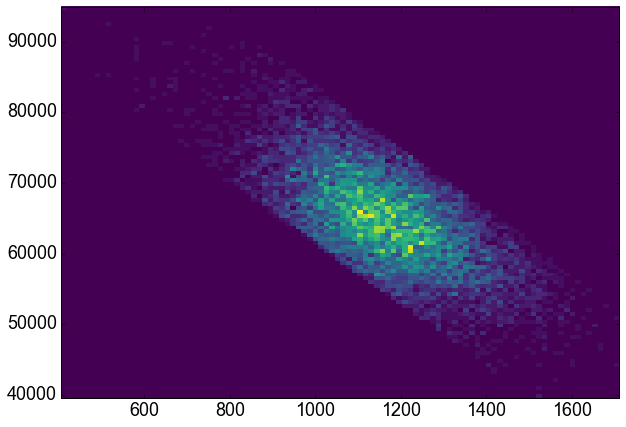

In [71]:
plt.hist2d(pp['cs1'], pp['s2_bot'], bins=100)
plt.show()


/home/erik/anaconda3/envs/pax/lib/python3.4/site-packages/ipykernel/__main__.py:30: InitialParamWarning: errordef is not given. Default to 1.
/home/erik/anaconda3/envs/pax/lib/python3.4/site-packages/ipykernel/__main__.py:30: InitialParamWarning: Parameter mu is floating but does not have initial step size. Assume 1.
/home/erik/anaconda3/envs/pax/lib/python3.4/site-packages/ipykernel/__main__.py:30: InitialParamWarning: Parameter sigma is floating but does not have initial step size. Assume 1.


FCN = -1765.7438504302945 
 TOTAL NCALL = 42 
 NCALLS = 42 
 
 
 EDM = 6.325765794527657e-07 
 GOAL EDM = 1e-05 
 
 UP = 1.0 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,mu,1158.03,2.24423,0,0,,,
2,sigma,206.061,2.94366,0,0,,,


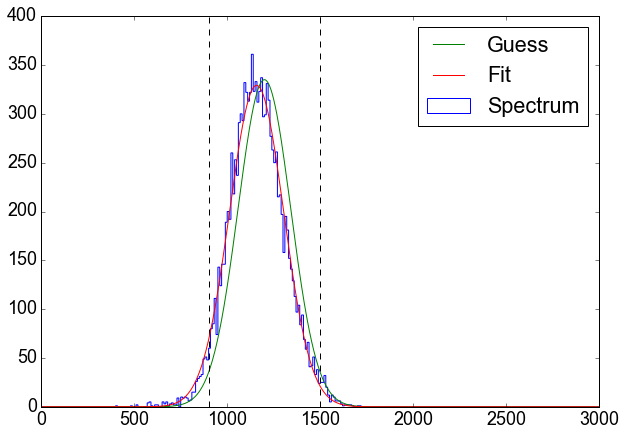

In [74]:
popt_cs1_it0, _ , _ =  fit_gaus(pp['cs1'], (900, 1500), 1200, 200, (0, 3000), 300)

/home/erik/anaconda3/envs/pax/lib/python3.4/site-packages/ipykernel/__main__.py:30: InitialParamWarning: errordef is not given. Default to 1.
/home/erik/anaconda3/envs/pax/lib/python3.4/site-packages/ipykernel/__main__.py:30: InitialParamWarning: Parameter mu is floating but does not have initial step size. Assume 1.
/home/erik/anaconda3/envs/pax/lib/python3.4/site-packages/ipykernel/__main__.py:30: InitialParamWarning: Parameter sigma is floating but does not have initial step size. Assume 1.


FCN = -416.57052667595894 
 TOTAL NCALL = 30 
 NCALLS = 30 
 
 
 EDM = 5.12443970713145e-06 
 GOAL EDM = 1e-05 
 
 UP = 1.0 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,mu,1154.2,2.7851,0,0,,,
2,sigma,202.409,5.20582,0,0,,,


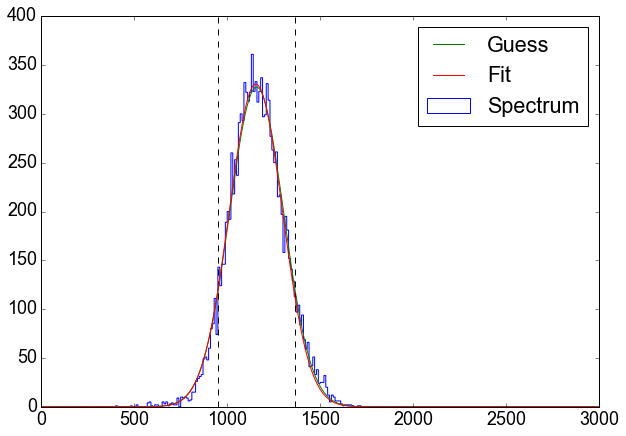

In [76]:
sigmas_to_select_cs1 = 1
popt_cs1_it1, m_cs1_it1 , _ =  fit_gaus(pp['cs1'], (popt_cs1_it0[0] - sigmas_to_select_cs1 * popt_cs1_it0[1], 
                                     popt_cs1_it0[0] + sigmas_to_select_cs1 * popt_cs1_it0[1])
                         , popt_cs1_it0[0], popt_cs1_it0[1], (0, 3000), 300)

In [77]:
m_cs1_it1.values

{'mu': 1154.2044765929927, 'sigma': 202.4085209368106}

In [80]:
m_cs1_it1.errors

{'mu': 2.785102481203028, 'sigma': 5.2058177291174665}

/home/erik/anaconda3/envs/pax/lib/python3.4/site-packages/ipykernel/__main__.py:30: InitialParamWarning: errordef is not given. Default to 1.
/home/erik/anaconda3/envs/pax/lib/python3.4/site-packages/ipykernel/__main__.py:30: InitialParamWarning: Parameter mu is floating but does not have initial step size. Assume 1.
/home/erik/anaconda3/envs/pax/lib/python3.4/site-packages/ipykernel/__main__.py:30: InitialParamWarning: Parameter sigma is floating but does not have initial step size. Assume 1.


FCN = -2431.0182920091866 
 TOTAL NCALL = 65 
 NCALLS = 65 
 
 
 EDM = 1.682323260692218e-06 
 GOAL EDM = 1e-05 
 
 UP = 1.0 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,mu,64832.1,89.0664,0,0,,,
2,sigma,9037.14,108.009,0,0,,,


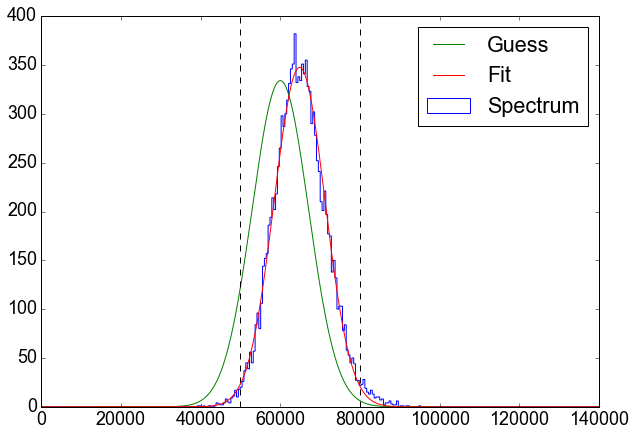

In [82]:
popt_cs2_it0, m_cs2_it0, _ = fit_gaus(pp['s2_bot'], (50e3, 80e3), 60e3, 10e3, (0, 140e3), 300, 1.)


/home/erik/anaconda3/envs/pax/lib/python3.4/site-packages/ipykernel/__main__.py:30: InitialParamWarning: errordef is not given. Default to 1.
/home/erik/anaconda3/envs/pax/lib/python3.4/site-packages/ipykernel/__main__.py:30: InitialParamWarning: Parameter mu is floating but does not have initial step size. Assume 1.
/home/erik/anaconda3/envs/pax/lib/python3.4/site-packages/ipykernel/__main__.py:30: InitialParamWarning: Parameter sigma is floating but does not have initial step size. Assume 1.


FCN = -379.47703953844575 
 TOTAL NCALL = 31 
 NCALLS = 31 
 
 
 EDM = 9.534114445674464e-07 
 GOAL EDM = 1e-05 
 
 UP = 1.0 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,mu,64617.9,127.885,0,0,,,
2,sigma,9089.34,244.508,0,0,,,


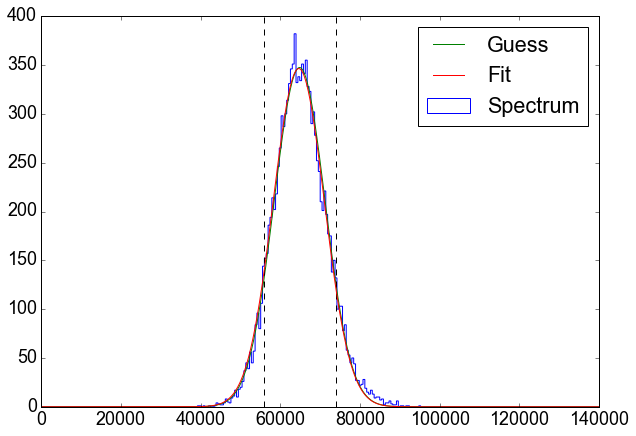

In [83]:
sigmas_to_select_cs2 = 1
popt_cs2_it1, m_cs2_it1, _ = fit_gaus(pp['s2_bot'], (popt_cs2_it0[0] - sigmas_to_select_cs2 * popt_cs2_it0[1],
                                                     popt_cs2_it0[0] + sigmas_to_select_cs2 * popt_cs2_it0[1]),
                                                     popt_cs2_it0[0], popt_cs2_it0[1], (0, 140e3), 300, 1.)

In [ ]:
x.add_ces()